# Lectures 7: Class demo

### Imports

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
from utils import *
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
%matplotlib inline
DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")
pd.set_option("display.max_colwidth", 200)

## Demo: Model interpretation of linear classifiers

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- For example, with the sign and magnitude of learned coefficients we could answer questions such as which features are driving the prediction to which direction. 

- We'll demonstrate this by training `LogisticRegression` on the famous [IMDB movie review](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset. The dataset is a bit large for demonstration purposes. So I am going to put a big portion of it in the test split to speed things up. 

In [2]:
imdb_df = pd.read_csv(DATA_DIR + "imdb_master.csv", encoding="ISO-8859-1")
imdb_df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


Let's clean up the data a bit. 

In [3]:
import re

def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub(r"https://\S*", "", doc)
    return doc

In [4]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

Are we breaking the Golden rule here? 

Let's split the data and create bag of words representation. 

In [5]:
train_df, test_df = train_test_split(imdb_df, test_size=0.9, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["sentiment"]
X_test, y_test = test_df["review_pp"], test_df["sentiment"]
train_df.shape

(5000, 3)

In [6]:
vec = CountVectorizer(stop_words="english")
bow = vec.fit_transform(X_train)
bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 439384 stored elements and shape (5000, 38867)>

### Examining the vocabulary

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names_out()` on the `CountVectorizer` object. 

In [7]:
vocab = vec.get_feature_names_out()

In [8]:
vocab[0:10]  # first few words

array(['00', '000', '007', '0079', '0080', '0083', '00pm', '00s', '01',
       '0126'], dtype=object)

In [9]:
vocab[2000:2010]  # some middle words

array(['apprehensive', 'apprentice', 'approach', 'approached',
       'approaches', 'approaching', 'appropriate', 'appropriated',
       'appropriately', 'approval'], dtype=object)

In [10]:
vocab[::500]  # words with a step of 500

array(['00', 'aaja', 'affection', 'ambrosine', 'apprehensive', 'attract',
       'barbara', 'bereavement', 'blore', 'brazenly', 'businessman',
       'carrel', 'chatterjee', 'claudio', 'commanding', 'consumed',
       'cramped', 'cynic', 'defining', 'deviates', 'displaced',
       'dramatized', 'edie', 'enforced', 'evolving', 'fanatically',
       'fingertips', 'formal', 'gaffers', 'giogio', 'gravitas',
       'halliday', 'heist', 'hoot', 'iliad', 'infiltrate', 'investment',
       'jobson', 'kidnappee', 'landsbury', 'licentious', 'lousiest',
       'malã', 'maã', 'mice', 'molla', 'museum', 'newtonian',
       'obsessiveness', 'outbursts', 'parapsychologist', 'perpetuates',
       'plasters', 'powers', 'property', 'rabies', 'reclined', 'renters',
       'ridiculous', 'rube', 'sayid', 'select', 'shivers', 'skinheads',
       'sohail', 'spot', 'stomaches', 'suitcase', 'syrupy', 'terrorist',
       'tolerance', 'triangular', 'unbidden', 'unrevealed', 'verneuil',
       'walrus', 'wilcox',

In [11]:
y_train.value_counts()

sentiment
positive    2517
negative    2483
Name: count, dtype: int64

### Model building on the dataset 

First let's try `DummyClassifier` on the dataset. 

In [12]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.004032,0.004408,0.504,0.50325
1,0.012923,0.006626,0.504,0.50325
2,0.004631,0.001745,0.503,0.50350
3,0.001176,0.000706,0.503,0.50350
4,0.001061,0.000693,0.503,0.50350


We have a balanced dataset. So the `DummyClassifier` score is around 0.5. 

Now let's try logistic regression. 

In [13]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000),
)
scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.441136,0.056777,0.828,0.99975
1,0.408053,0.059261,0.830,0.99975
2,0.422930,0.057598,0.848,0.99975
3,0.403875,0.057569,0.833,1.00000
4,0.402541,0.058259,0.840,0.99975


Seems like we are overfitting. Let's optimize the hyperparameter `C` of LR and `max_features` of `CountVectorizer`. 

In [17]:
scores_dict = {
    "C": 10.0 ** np.arange(-3, 3, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_lr = make_pipeline(CountVectorizer(max_features=10_000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C=C)
                       )
    scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.001,0.82615,0.7864
1,0.010,0.91795,0.8322
2,0.100,0.98570,0.8422
3,1.000,0.99980,0.8340
4,10.000,1.00000,0.8256
5,100.000,1.00000,0.8312


In [18]:
optimized_C = results_df["C"][results_df["mean_cv_scores"].idxmax()]
print(
    "The maximum validation score is %0.3f at C = %0.2f "
    % (
        np.max(results_df["mean_cv_scores"]),
        optimized_C,
    ))

The maximum validation score is 0.842 at C = 0.10 


In [19]:
pipe_lr = make_pipeline(CountVectorizer(max_features=10000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C = 0.10)
                       )
pipe_lr.fit(X_train, y_train)

,steps,"[('countvectorizer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### Examining learned coefficients 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 

In [20]:
# Get feature names
feature_names = pipe_lr.named_steps['countvectorizer'].get_feature_names_out().tolist()

# Get coefficients 
coeffs = pipe_lr.named_steps["logisticregression"].coef_.flatten()

In [21]:
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df

,Coefficient
00,0.058621
000,0.075009
007,0.005351
10,0.184220
100,-0.067604
...,...
zone,0.000927
zoo,-0.069953
zorro,0.041716
zu,0.072167


- Let's sort the coefficients in descending order. 
- Interpretation
    - if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$. 
    - if $w_j < 0$ then increasing $x_{ij}$ moves us toward predicting $-1$. 


In [22]:
word_coeff_df.sort_values(by="Coefficient", ascending=False)

,Coefficient
excellent,0.794894
amazing,0.622091
perfect,0.608633
wonderful,0.571676
great,0.535896
...,...
waste,-0.683588
terrible,-0.719606
boring,-0.725668
awful,-0.872302


- The coefficients make sense!

Let's visualize the top 20 features.

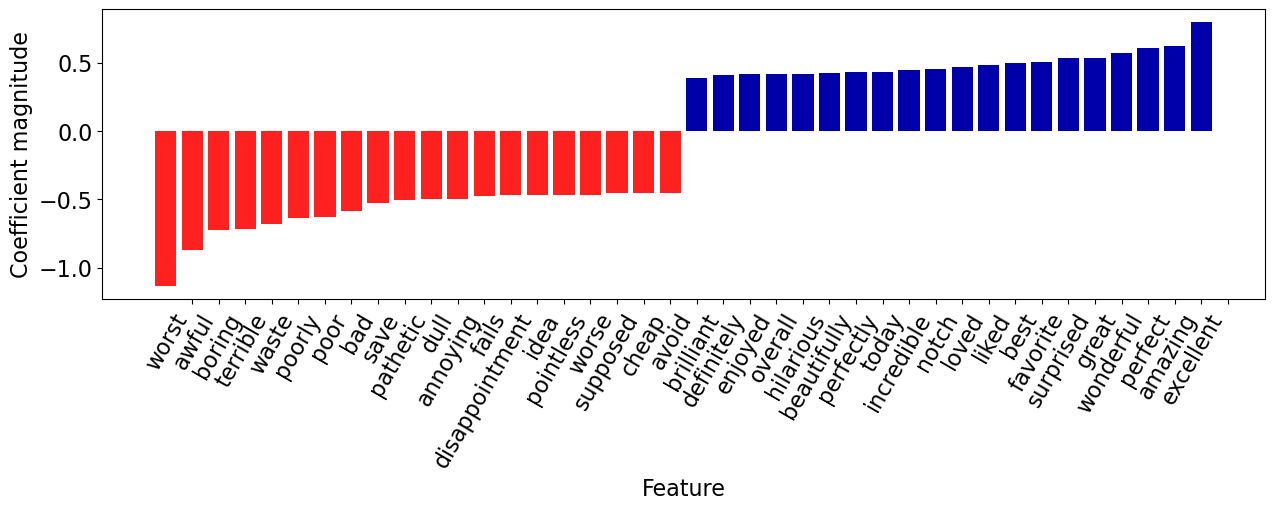

In [23]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=20)

Let's explore prediction of the following new review. 

In [25]:
fake_reviews = ["It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!",
 "The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen."
]
fake_reviews

['It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!',
 'The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen.']

Let's get prediction probability scores of the fake review. 

In [26]:
pipe_lr.predict(fake_reviews)

array(['positive', 'negative'], dtype=object)

In [27]:
# Get prediction probabilities for fake reviews 
pipe_lr.predict_proba(fake_reviews)

array([[0.17333954, 0.82666046],
       [0.68822214, 0.31177786]])

In [28]:
pipe_lr.classes_

array(['negative', 'positive'], dtype=object)

We can find which of the vocabulary words are present in this review:

In [29]:
def plot_coeff_example(model, review, coeffs, feature_names, n_top_feats=6):
    print(review)
    feat_vec = model.named_steps["countvectorizer"].transform([review])
    words_in_ex = feat_vec.toarray().ravel().astype(bool)

    ex_df = pd.DataFrame(
        data=coeffs[words_in_ex],
        index=np.array(feature_names)[words_in_ex],
        columns=["Coefficient"],
    )
    mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=n_top_feats
    )
    return ex_df.sort_values(by=["Coefficient"], ascending=False)

It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!


,Coefficient
excellent,0.794894
overall,0.417289
enjoyed,0.416470
highly,0.328111
bit,0.327412
times,0.227090
recommend,0.172985
flawless,0.066854
movie,-0.033348
got,-0.087397


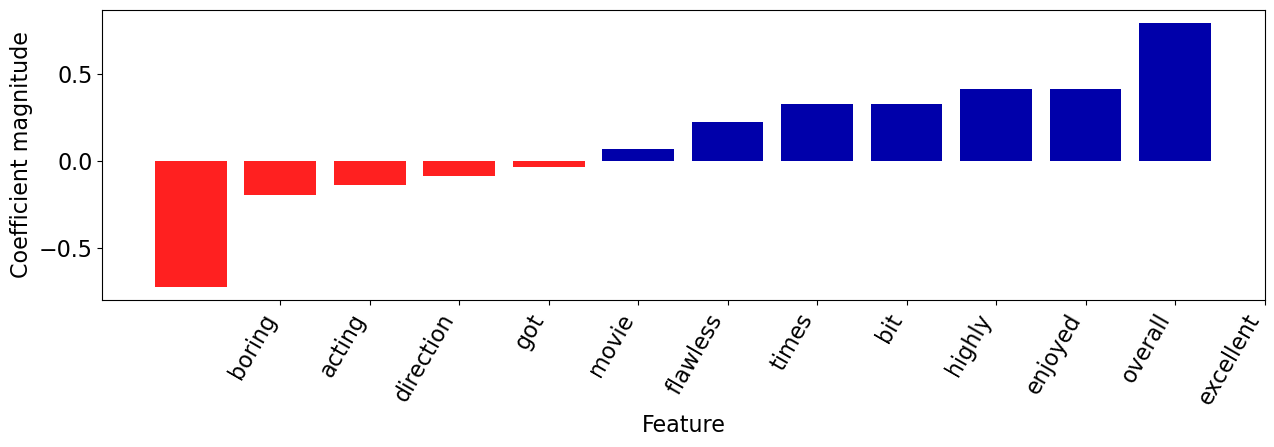

In [30]:
plot_coeff_example(pipe_lr, fake_reviews[0], coeffs, feature_names)

In [ ]:
plot_coeff_example(pipe_lr, fake_reviews[1], coeffs, feature_names)

<br><br><br><br>

### Most positive review 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the reviews where our classifier is most certain or least certain?

In [31]:
# only get probabilities associated with pos class
pos_probs = pipe_lr.predict_proba(X_train)[
    :, 1
]  # only get probabilities associated with pos class
pos_probs

array([0.97581663, 0.27576982, 0.93402132, ..., 0.75329946, 0.87516818,
       0.00630932], shape=(5000,))

What's the index of the example where the classifier is most certain (highest `predict_proba` score for positive)?

In [32]:
most_positive_id = np.argmax(pos_probs)

In [33]:
print("True target: %s\n" % (y_train.iloc[most_positive_id]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_positive_id]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_positive_id]))

True target: positive

Predicted target: positive

Prediction probability: 1.0000


Let's examine the features associated with the review. 

In [ ]:
plot_coeff_example(pipe_lr, X_train.iloc[most_positive_id], coeffs, feature_names)

The review has both positive and negative words but the words with **positive** coefficients win in this case! 

### Most negative review 

In [ ]:
neg_probs = pipe_lr.predict_proba(X_train)[
    :, 0
]  # only get probabilities associated with neg class
neg_probs

In [ ]:
most_negative_id = np.argmax(neg_probs)

In [ ]:
print("Review: %s\n" % (X_train.iloc[[most_negative_id]]))
print("True target: %s\n" % (y_train.iloc[most_negative_id]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_negative_id]])[0]))
print("Prediction probability: %0.4f" % (neg_probs[most_negative_id]))

In [ ]:
plot_coeff_example(pipe_lr, X_train.iloc[most_negative_id], coeffs, feature_names)

The review has both positive and negative words but the words with negative coefficients win in this case! 

## ❓❓ Questions for you

#### Question for you to ponder on 

- Is it possible to identify most important features using $k$-NNs? What about decision trees?  
